<font face="Calibri" size=5>Credit Valuation Adjustment on Derivative Instruments </font>

This is a Python 3 version of a CVA project.
- The project was done in a 5 person team, over multiple weeks, in a Financial Engineering course.
- The original code was in R, and much of the visual analysis was in Excel.
- This is my conversion, and revision of the R code - done individually.

<font color="blue">Goal: A report describing applied methodologies, as well as CVA calculations for different types of derivative insturments.</font>


<hr>

<font size=2>Global Imports</font>

In [1]:
# For data supplied frmo the market, etc
import pandas as pd

# Mostly to run a cubic spline interpolation
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


<hr>

<font face="Calibri" size=4>Part 0. Description of the Derivative Instruments
</font>

- 1. Buy **EUR** sell PLN FX Forward  
(maturity: 1 year, notional: 100 000 EUR; strike: 4.3930)


- 2. Receiver (We receive fixed rate) PLN WIBOR 3M IRS  
(maturity: 3 years, notional: 500 000 PLN; fixed rate: 2.2144% - paid annually)


- 3. EUR/PLN CIRS, paid rate: fixed rate (-0,0575%) in EUR,  
received rate WIBOR 3M, notional exchange at the beginning as well as end of the contract  
(maturity: 3 years, notional: 100 000 EUR/ 430 000 PLN)

<font face="Calibri" size=4>Part I. Analysis of Instruments
</font>
- ### Mechanics
- ### Payoff formulars & Payoff Profiles
- ### Valuation Formulas

<font face="Calibri" size=4>Part II. Implied Defauly Probability
</font>
- ### CDS Contracts
  - Mechanics
  - Valuation
- ### Implying Probability of Default from a CDS spread
  - CDS bootsrapping
  - CDS bootstrapping from sample market quotes

<font color=#cc33ff>__[+] CDS Contracts Mechanics and Valuation__</font>

Credit Default Swaps are a type of credit derivatives in which the credit exposure of a loan or a fixed income security is transferred to the swap counterparty for a fees. The buyer of the CDS is protected from the risk of the loan defaulting.

A credit default swap (CDS) is a contract that gives the buyer of the contract a right to receive compensation from the seller of the contract in the event of default of a third party. The buyer of the contract is typically a bondholder who is looking to transfer his credit exposure to another party. The seller is typically a bank which earns from the premiums it receives from the buyer.

Each CDS has a notional amount and it requires the buyer to pay a premium called CDS spread.

The seller of the CDS pays the buyer an amount equal to the loss incurred by the buyer on occurrence of a credit event. The credit event is binary in nature, i.e. it occurs, or it doesn’t. Typical credit events include (a) a filing for bankruptcy by the third party on whose bond the CDS was issued, (b) any failure by the third party to pay interest on its bonds and (c) any restructuring of the debt.


Payout Amount = N x Payout Ratio = N x (1 - Recovery Rate)

Where N is the notional amount

During the life of the CDS, the profit (loss) that accrues to the buyer (seller) of the CDS can be approximated as follows:

Profit to buyer of CDS = $\Delta CDS*N*D$

ΔCDS is the basis point change in credit spread, N is the notional amount and D is the duration of the bond.

It follows that if the default spread increases over the life of the CDS, the buyer gains and if the spread shrinks the seller gains.



<font color=#cc33ff>__[+] Data__</font>

In [2]:
# As CDS spreads are not readily available for free,
# this market data was supplied as part of the project.
# The data, oringinal in .xlsx, has been copied into Pandas DataFrames.

# Our CDS data has tenors of .5 years to 10 yrs. 
# We add a column for this length, in years

cds_data ={
    "CDS_DB":["DB6MEUSM=R", "DB1YEUSM=R", "DB2YEUSM=R", "DB3YEUSM=R",
              "DB4YEUSM=R", "DB5YEUSM=R", "DB7YEUSM=R","DB10YEUSM=R"],
    "CDS_Tenor":[0.5, 1, 2, 3, 4, 5, 7, 10],
    "Close" :[35.88, 39.40, 69.35, 96.70,
              123.33,152.07,196.58,223.30]}

Market_CDS_Spreads = pd.DataFrame(cds_data)
Market_EURPLN_Xr = 4.3000

# The index in this DataFrame represents the number of months into the future
Discount_Factors = pd.read_csv("discfac.csv")
# for ease of use, we also add timespan in years to the DscFctr dframe
Discount_Factors["DF_Tenor"] = [tm/12 for tm in range(61)]
Discount_Factors = Discount_Factors[["DF_Tenor","EUR_DF",
                                     "PLN_DF","EUR/PLN"]]

In [3]:
Discount_Factors

,DF_Tenor,EUR_DF,PLN_DF,EUR/PLN
0,0.000000,1.000000,1.000000,4.3000
1,0.083333,1.000395,0.998300,4.3090
2,0.166667,1.000639,0.997183,4.3149
3,0.250000,1.000881,0.995828,4.3218
4,0.333333,1.001156,0.994414,4.3292
...,...,...,...,...
56,4.666667,0.991033,0.892382,4.7754
57,4.750000,0.990337,0.890101,4.7842
58,4.833333,0.989622,0.887798,4.7932
59,4.916667,0.988889,0.885484,4.8021


In [4]:
print(Market_CDS_Spreads)
print("\nEUR/PLN :",Market_EURPLN_Xr,'\n')
#print("---- Discount_Factors ----\n")
#print(Discount_Factors.info())
#print(Discount_Factors.head(),'\n',Discount_Factors.tail())

        CDS_DB  CDS_Tenor   Close
0   DB6MEUSM=R        0.5   35.88
1   DB1YEUSM=R        1.0   39.40
2   DB2YEUSM=R        2.0   69.35
3   DB3YEUSM=R        3.0   96.70
4   DB4YEUSM=R        4.0  123.33
5   DB5YEUSM=R        5.0  152.07
6   DB7YEUSM=R        7.0  196.58
7  DB10YEUSM=R       10.0  223.30

EUR/PLN : 4.3 



<font color=#cc33ff>__[+] Implying PD from CDS spreads: Bootstrapping__</font>

_Bootsrapping is any test or metric that relies on random sampling with replacement. It allows assigning measures of accuracy __(defined in terms of bias, variance, confidence intervals, prediction error, etc)__ to sample estimates. This techinique allows estimation of the sampling distribution of almost any statistic, using random sampling methods. (Wikipedia)_

Given the information in `Market_CDS_Spreads`, we would like to us an interpolaiton method, to create spread values for monthly intervals up to the duration of our longest insturment: 3 years.

The `Market_CDS_Spreads` serve as input to a function for curve-fitting to find these intermediate values, not explicitly in the list of spread tenors. For this approximation, we will use a spline method; namely, cubic splines.

__Cubic Splines__  
For each $n$ points of data, the spline method fits a cubic function through the points. By _through_, we mean that specific points in the data must also lie on the function. Additionally, the method adds constrains/requirements that the $first$ and $second$ derivatives of the curves, fit over various intervals, match. Even though, the process is piecewise, the added requirements create a smooth approximation.

In [5]:
# Load the CDS Tenors into a var
cdstenor_tm = Market_CDS_Spreads.CDS_Tenor
cdsspread_amt = Market_CDS_Spreads.Close

In [6]:
# Fit spline to the data. default for k = 3 for cubic. s is smoothing level
tck = interpolate.splrep(x = cdstenor_tm, y = cdsspread_amt, s=0)

In [7]:
tck

(array([ 0.5,  0.5,  0.5,  0.5,  2. ,  3. ,  4. ,  5. , 10. , 10. , 10. ,
        10. ]), array([ 35.88      ,  32.23146303,  67.57692568,  96.46494703,
        122.63642602, 193.41324605, 221.70253173, 223.3       ,
          0.        ,   0.        ,   0.        ,   0.        ]), 3)

We now use the fitted data to created interpolated points at the monthly intervals for our instruments.

In [8]:
# Load the 36-month time interval into a separate var
month_dur = Discount_Factors.DF_Tenor[:37]
month_dur[-3:]

34    2.833333
35    2.916667
36    3.000000
Name: DF_Tenor, dtype: float64

In [9]:
interp_CDS_amt = interpolate.splev(month_dur, tck, der=0)

In [10]:
interp_CDS_amt

array([48.93054304, 45.32036668, 42.32558519, 39.91517819, 38.05812526,
       36.72340599, 35.88      , 35.49688687, 35.54304619, 35.98745757,
       36.79910061, 37.94695488, 39.4       , 41.12721556, 43.09758115,
       45.28007637, 47.64368081, 50.15737408, 52.79013576, 55.51094546,
       58.28878276, 61.09262728, 63.89145859, 66.6542563 , 69.35      ,
       71.95433753, 74.46958967, 76.90474545, 79.26879389, 81.57072401,
       83.81952484, 86.0241854 , 88.19369471, 90.33704181, 92.4632157 ,
       94.58120543, 96.7       ])

$\uparrow$ Above, in `intepr_CDS_amt` we can see values from the `Close` column show up, as they should, for known tenors.

$\downarrow$ Let's plot what's happened

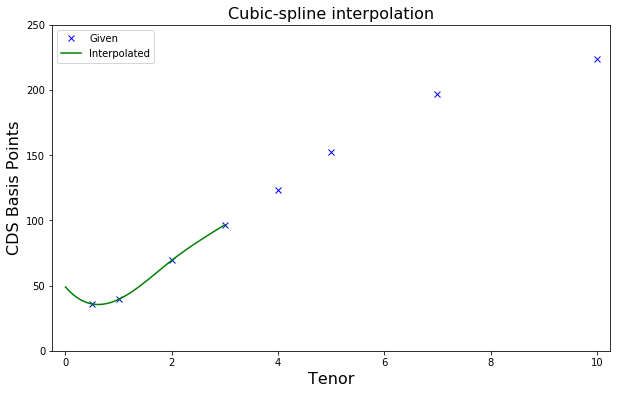

In [11]:
plt.figure(figsize=(10,6))
plt.plot(cdstenor_tm, cdsspread_amt, 'xb', month_dur, interp_CDS_amt, 'g')
plt.legend(['Given', 'Interpolated'])
plt.xlabel("Tenor",fontsize=16)
plt.ylabel("CDS Basis Points",fontsize=16)
plt.axis([-0.25, 10.25, 0, 250])
plt.title('Cubic-spline interpolation',fontsize=16)
plt.show()

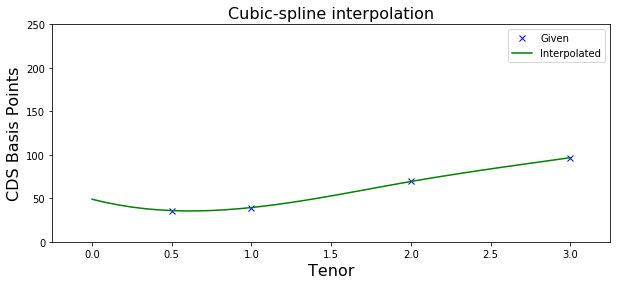

In [12]:
plt.figure(figsize=(10,4))
plt.plot(cdstenor_tm[:4], cdsspread_amt[:4], 'xb', month_dur, interp_CDS_amt, 'g')
plt.legend(['Given', 'Interpolated'])
plt.xlabel("Tenor",fontsize=16)
plt.ylabel("CDS Basis Points",fontsize=16)
plt.axis([-0.25, 3.25, 0, 250])
plt.title('Cubic-spline interpolation',fontsize=16)
plt.show()

The `interp_CDS_amt` array gives use one value for a CDS spread, per month, based on the observed initial quote data. We can now move forward to find Implied Default Probabilities.

<font color=#cc33ff>__[+] Implying PD from CDS spreads: Probability of Default__</font>

<font color ="blue">The relation between a Credit Default Swap and the Probability of Default</font>

Consider a CDS contract with maturity $T_n$ with spread $S_{t,T_i}$
- The $T_1...T_n$ are the dates when the premium is paid
- The $\Delta T_i~=~T_i - T_{i-1}$ , $t = T_0 < T_1$

The Probability of Default can be written as

$PD_{t,T} := \mathbb{N}(\tau \in (t,T)~|~\mathcal{F}_t,\tau > t)$

- t - current moment
- $\tau$ - time of default
- $\mathbb{N}$ - risk-neutral probability measure
- $\mathcal{F}_t$ - time-$t$ filtration

#### Translation  
The **Probability of Default** at time $t$ for a contract maturing at time $T$ is given by:  
- the risk-neutral probability measure of the **time of default** $\tau$ (which is within the range of $now$ to $maturity$) under the filtration of all events/ up to now ($t$) where $\tau$ is greater than $t$.


<font color ="blue">The relation between a Credit Default Swap and the Probability of Default</font>

__CDS valuation - First Leg__ (Default Leg)
- if the credit event occurs, the first leg is
  - (1-RR) x N x $\sum_{i=1}^{n}(DF_i * DP_i)$
    - RR - recovery rate
    - N - notional amount
    - $DF_i$ discount factor for risk-free rate, at time i
    - $DP_i$ is the default probability
    - $n$ - number of periodic payments
    
__CDS Valuation - Second Leg__ (Fixed Leg / Premium Leg)
- if the credit event __does not__ occur, the second leg is
  - N x $\sum_{i=1}^{n}(s * DF_i * SP_i)$
    - N is the notional amount
    - $DF_i$ - the discount factor for the risk-free rate
    - $SP_i$ - the survival probability := $(1-DP_i)$
    - $n$ is the number of periodic payments
    - s - is the CDS premium or "spread"
  - $s$ is not time-dependent because the 2$^{nd}$ leg is the _fixed_ leg.

$\Rightarrow$ the above two imply that the __value of the CDS spread__ $s$ should be as follows:

## $s~=~\frac{(1-RR)~\times~\sum_{i=1}^{n}(DF_i~\times~DP_i)}{\sum_{i=1}^{n}(DF_i~\times~SP_i)}$

We can think of $s$ (the quoted spread) as the sum of all fixed payments over the full contract length. Meaning, $s$ is divided over the time interval.

<font size=2><i>
slide 14:<br>
<br>
Premium Leg: both $N$ should be capital N. for $S_N$ it's missing the multiplication by the survivial prob<br>
<br>
after the+ is NOT part of the summation. It's what you'd pay if the defauly is not exactly on a payment date.<br>
<br>
the 2 is actually a smiplified way of saying "the aount of the time segemtn you've gone through". We assume half way through, and just divide by two.<br>
<br>
On slide 4. This clashes with our earlier slides.<br>
<br>
the $S_N$ should eithe rbe inside the parenthesis, or it represents the lump sum of $n * s$ i.e. $S$ instea dof lower case $s$. Either way, the $S_N$ on page 14 should, outside of the parenthesis shoudl be ALL paymenets, but inside should be the "quoted" spread (like form the historical quotes).
</i></font>

**The harzard rate is the instantaneous rate of probability of default. it's distribution is Poisson.**

Since the spread of the CDS is already given on the market, we can reformulate the equations and solve instead for $DP_i$, the implied probability of default.

This is the implied probability of default un the assumption (or requirement) that the two legs of the CDS are equal to each other at the start of the contract. Thus, we must lookat the present value of each leg, and extract the default probability from that expression

<font color ="blue">The Present Value of the Premium and Default legs of the CDS</font>

For the defualt leg, we previously showed it present value to be
- 1a. $(1-RR)~\times~N~\times~\sum_{i=1}^{n}(DF_i * DP_i)$

Ignoring the notional (setting it to 1), we can express this with some slight changes. The present value of the Default Leg can be written as
- 1b. $DL ~ = ~ (1-RR) ~ \dot ~ \sum_{i=1}^{n} DF_i ~ \dot ~~ [SP_{i-1} - SP_{i} ] $

---

For the Premium leg, we previously showed its present value to be
- 2a. $N~\times~\sum_{i=1}^{n}(s * DF_i * SP_i)$ <font size=1>,where N is the notional amount</font>

Ignoring the notional (setting it to 1), we can express this with some slight changes. The present value of the Premium Leg can be written as
- 2b. $PL_T~=s_T~\dot~\sum_{i=1}^{n}(DF_i~\dot~~SP_i~\dot~~\Delta t_i)~~ + ~~(s_T~\dot~~q~\dot~~\sum_{i=1}^{n}(DF_i~\dot~~[SP_{i-1}-SP_i])~)$


<font color ="blue">Explanation of CDS Present Value Equations (1b and 2b)</font>

#### Default Leg (1b)
\- (1-RR) : this is LGD, the loss given default  
\- $DF_i$ : the discount factor from time 0 up to time $i$  
\- $[SP_{i-1} - SP_{i} ]$ : a difference of two Survival Probabilities. This diefference is the probability of defaulting within the time interval from $i-1$ to $i$.  
\- __In English__ : The Present Value of the Default Leg is the Loss Given Default, multiplied to the sum of the product of two items: the discount factor from 0 to i, and the probablity of defaulting in the current interval.

#### Premium Leg (2b)
<font size=2>We write this valuaiton with the assumption that a default happens</font>  
\- $s_T$ : the spread associated with a CDS of Tenor $T$.  
- Left of the $+$ sign  
\- the first sum : In this sum, the discount factor is scaled by the time interval associated with the index i. These two items are mulitplied with the probability of surviving up to time i.  $\star$ __If we default at or before time $i$, then $SP_i = 0$__  
- Right of the $+$ sign  
\- $s_T$ : as described before  
\- $q$ : When a default occurs, this is the fraction of the current time interval that has elapsed. For simplicity, we can always take $q=\frac{1}{2}$. Otherwise, $q$ is $\Delta t_i$ divided by the (Default time - $t_{i-1}$)  
\- the second sum: __This doesn't need to be a sum__. If the instrument has not defaulted in this interval, then both Survival probabilities equal $1$.  

(They aren't exactly 1. However, from the perspective of us being at time i, and having all previous information, then yes, there is a 100% chance of surviving to the previous itme point, because it did.)  

The difference becomes zero. Thus the sum is 0, and the whole right side is zero. Therefore, using the summation is useless. However, if the defaut occurs then $SP_{i-1}$ will be non-zero, but $SP_i$ will be zero. We will therefore pay the fraction of $s_T$ corresponding to the fraction of the interval that elapsed before default. (We don't need to sum up all of the intervals where there was no default on this side of the $+$)

Since $s_T$ is on the side of the Premium Leg, we divide the Default Leg equation by the rest of the premium leg equation, to get the value of $s_T$. 

More importantly, we need to extract the Probability of Default from these equations. To do this, we solve for the Probability of Survival, and then use its complement - the Probability of Default.

<font face="Calibri" size=4>Part III. Risk Factors Simulation
</font>
- ### Simulation Methodolody
- ### Calibration to Market Data
- ### Simulation: 3 years, 1 month time step, $M$ simulations

<font face="Calibri" size=4>Part IV. Calculation of Expoected Exposure Profiles
</font>
- ### Expected Exposure (EE) profile for each derivative in question
- ### Identification and presentation of the key features of EE, per derivative
- ### Sensitivity analysis of volatility changes, on Expected Exposure

<font face="Calibri" size=4>Part V. CVA Calculation for Each Derivative
</font>
- ### CVA per derivative
- ### Sensitivity analysis of volatility changes on CVA